In [1]:
!pip install torch==2.9.1
!pip install torch-geometric==2.3.0
!pip install pyhealth==1.1.2
!pip install scikit-learn==1.2.1
!pip install openai==0.27.4
!pip install neptune

  Using cached scikit-learn-1.2.1.tar.gz (7.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\Dell\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^^^
 

In [1]:
import sys
import os
import pickle
import json
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, k_hop_subgraph
import networkx as nx
from tqdm.notebook import tqdm
from sklearn.metrics import (
    average_precision_score, roc_auc_score, accuracy_score, 
    f1_score, precision_score, recall_score, jaccard_score, cohen_kappa_score
)
import logging

# Ensure local modules can be imported
sys.path.append(os.getcwd())

# Import from the repository structure
# These imports assume the notebook is in the root of the 'graphcare' repo
from graphcare_ import split_by_patient, GraphCare

# --- CONFIGURATION ---
# Run this cell to switch from "Mock Gen" mode back to "Training" mode.

class Args:
    def __init__(self):
        # Paths (Must match where you saved the mock data)
        self.mimic_root = "C:/Users/Dell/Desktop/mimic3"
        self.data_cache = "./exp_data"
        self.kg_root = "./graphs"
        
        # Experiment Settings
        self.dataset = 'mimic3'
        self.task = 'mortality'
        self.kg = 'GPT-KG'
        self.device = 0
        
        # Hyperparameters
        self.batch_size = 4
        self.hidden_dim = 512
        self.epochs = 100
        self.lr = 1e-5
        self.weight_decay = 1e-5
        self.dropout = 0.5
        self.num_layers = 1
        self.decay_rate = 0.01
        self.freeze_emb = "False"
        self.patient_mode = 'joint'
        self.alpha = "True"
        self.beta = "True"
        self.edge_attn = "True"
        self.gnn = "BAT"
        self.attn_init = "False"
        self.in_drop_rate = 0.0
        
        # The missing attribute causing your error:
        self.kg_ratio = 1.0
        self.train_ratio = 1.0

# Re-initialize args
args = Args()
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else 'cpu')
print(f"Configuration restored. Ready to train on device: {device}")

Configuration restored. Ready to train on device: cpu


In [3]:
# --- MOCK KG GENERATOR (Windows Fix) ---
import os
import json
import csv
import pickle
import numpy as np
from tqdm.notebook import tqdm

class MockKGConfig:
    def __init__(self):
        self.res_dir = "./resources"
        self.graph_dir = "./graphs/cond_proc_drug/CCSCM_CCSPROC_ATC3"
        self.data_dir = "./exp_data/ccscm_ccsproc_atc3"
        self.emb_dim = 1536 
        
args = MockKGConfig()

os.makedirs(args.graph_dir, exist_ok=True)
os.makedirs(args.data_dir, exist_ok=True)

def load_all_codes(res_dir):
    print("Gathering medical codes from resources...")
    codes = set()
    
    # ADDED encoding='utf-8' to all open() calls
    try:
        with open(os.path.join(res_dir, "CCSCM.csv"), 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader: codes.add(row['code'])
                
        with open(os.path.join(res_dir, "CCSPROC.csv"), 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader: codes.add(row['code'])
                
        with open(os.path.join(res_dir, "ATC.csv"), 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row['level'] == '3.0': codes.add(row['code'])
    except UnicodeDecodeError:
        print("Warning: UTF-8 failed, trying 'latin1'...")
        # Fallback if your CSVs are actually ANSI encoded
        with open(os.path.join(res_dir, "CCSCM.csv"), 'r', encoding='latin1') as f:
             reader = csv.DictReader(f)
             for row in reader: codes.add(row['code'])
                
    print(f"Found {len(codes)} unique medical codes.")
    return list(codes)

def generate_mock_files(codes, args):
    print("Generating mock KG files...")
    ent2id = {code: i for i, code in enumerate(codes)}
    rels = ["caused_by", "treated_with", "associated_with"]
    rel2id = {r: i for i, r in enumerate(rels)}
    
    # JSON writes need encoding='utf-8'
    with open(os.path.join(args.graph_dir, "ent2id.json"), "w", encoding='utf-8') as f:
        json.dump(ent2id, f)
    with open(os.path.join(args.graph_dir, "rel2id.json"), "w", encoding='utf-8') as f:
        json.dump(rel2id, f)
        
    print("Generating random embeddings...")
    ent_emb = np.random.rand(len(ent2id), args.emb_dim)
    rel_emb = np.random.rand(len(rel2id), args.emb_dim)
    
    # Pickle is binary ('wb'), so NO encoding needed here
    with open(os.path.join(args.graph_dir, "entity_embedding.pkl"), "wb") as f:
        pickle.dump(ent_emb, f)
    with open(os.path.join(args.graph_dir, "relation_embedding.pkl"), "wb") as f:
        pickle.dump(rel_emb, f)

    print("Generating id2clus mappings...")
    ccscm_map = {}
    with open(os.path.join(args.res_dir, "CCSCM.csv"), 'r', encoding='utf-8', errors='ignore') as f:
        for row in csv.DictReader(f):
            if row['code'] in ent2id: ccscm_map[row['code']] = ent2id[row['code']]

    ccsproc_map = {}
    with open(os.path.join(args.res_dir, "CCSPROC.csv"), 'r', encoding='utf-8', errors='ignore') as f:
        for row in csv.DictReader(f):
            if row['code'] in ent2id: ccsproc_map[row['code']] = ent2id[row['code']]

    atc3_map = {}
    with open(os.path.join(args.res_dir, "ATC.csv"), 'r', encoding='utf-8', errors='ignore') as f:
        for row in csv.DictReader(f):
            if row['level'] == '3.0' and row['code'] in ent2id:
                atc3_map[row['code']] = ent2id[row['code']]
                
    with open(os.path.join(args.data_dir, "ccscm_id2clus.json"), "w", encoding='utf-8') as f:
        json.dump(ccscm_map, f)
    with open(os.path.join(args.data_dir, "ccsproc_id2clus.json"), "w", encoding='utf-8') as f:
        json.dump(ccsproc_map, f)
    with open(os.path.join(args.data_dir, "atc3_id2clus.json"), "w", encoding='utf-8') as f:
        json.dump(atc3_map, f)
        
    map_cluster = {}
    map_cluster_inv = {}
    for i in range(len(codes)):
        s_i = str(i)
        map_cluster[s_i] = {'nodes': [i], 'embedding': [ent_emb[i].tolist()]}
        map_cluster_inv[s_i] = s_i 

    map_cluster_rel = {}
    map_cluster_rel_inv = {}
    for i in range(len(rels)):
        s_i = str(i)
        map_cluster_rel[s_i] = {'relations': [i], 'embedding': [rel_emb[i].tolist()]}
        map_cluster_rel_inv[s_i] = s_i

    th = "th015"
    with open(os.path.join(args.data_dir, f"clusters_{th}.json"), "w", encoding='utf-8') as f:
        json.dump(map_cluster, f)
    with open(os.path.join(args.data_dir, f"clusters_inv_{th}.json"), "w", encoding='utf-8') as f:
        json.dump(map_cluster_inv, f)
    with open(os.path.join(args.data_dir, f"clusters_rel_{th}.json"), "w", encoding='utf-8') as f:
        json.dump(map_cluster_rel, f)
    with open(os.path.join(args.data_dir, f"clusters_inv_rel_{th}.json"), "w", encoding='utf-8') as f:
        json.dump(map_cluster_rel_inv, f)
        
    print(f"SUCCESS: Mock KG files generated.")

try:
    all_codes = load_all_codes(args.res_dir)
    generate_mock_files(all_codes, args)
except FileNotFoundError as e:
    print(f"Error: {e}")

Gathering medical codes from resources...
Found 565 unique medical codes.
Generating mock KG files...
Generating random embeddings...
Generating id2clus mappings...
SUCCESS: Mock KG files generated.


In [5]:
# --- STEP 1: CORRECTED DATA PREP (Renames relation -> edge_attr) ---
import os
import json
import pickle
import numpy as np
import networkx as nx
import torch
from collections import defaultdict
from tqdm import tqdm
from pyhealth.datasets import MIMIC3Dataset
from graphcare_.task_fn import mortality_prediction_mimic3_fn

class PrepConfig:
    def __init__(self):
        self.mimic_root = "C:/Users/Dell/Desktop/mimic3"
        self.output_dir = "./exp_data/ccscm_ccsproc_atc3"
        self.kg_dir = "./graphs/cond_proc_drug/CCSCM_CCSPROC_ATC3"
        self.dataset = "mimic3"
        self.task = "mortality"
        self.threshold = 0.15

prep_args = PrepConfig()

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list): result.extend(flatten(item))
        else: result.append(item)
    return result

def load_embeddings(args):
    print("Loading KG embeddings...")
    with open(os.path.join(args.kg_dir, "ent2id.json"), 'r', encoding='utf-8') as f:
        ent2id = json.load(f)
    with open(os.path.join(args.kg_dir, "rel2id.json"), 'r', encoding='utf-8') as f:
        rel2id = json.load(f)
    with open(os.path.join(args.kg_dir, "entity_embedding.pkl"), 'rb') as f:
        ent_emb = pickle.load(f)
    return ent2id, rel2id, ent_emb

def load_maps(args):
    print("Loading ID mappings...")
    def load_json_safe(fname):
        path = os.path.join(args.output_dir, fname)
        if os.path.exists(path):
            with open(path, 'r', encoding='utf-8') as f: return json.load(f)
        return {}
    return (load_json_safe("ccscm_id2clus.json"), 
            load_json_safe("ccsproc_id2clus.json"), 
            load_json_safe("atc3_id2clus.json"))

def process_and_save(args):
    ent2id, rel2id, ent_emb = load_embeddings(args)
    ccscm_map, ccsproc_map, atc3_map = load_maps(args)
    num_nodes = len(ent_emb)

    print("Loading MIMIC-III data...")
    ds = MIMIC3Dataset(
        root=args.mimic_root,
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        code_mapping={
            "NDC": ("ATC", {"target_kwargs": {"level": 3}}),
            "ICD9CM": "CCSCM",
            "ICD9PROC": "CCSPROC"
        },
    )
    sample_dataset = ds.set_task(mortality_prediction_mimic3_fn)

    print("Building Graph...")
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, x=ent_emb[i], y=i)
        
    if num_nodes > 0:
        for i in range(num_nodes):
            # FIX: Use 'edge_attr' instead of 'relation'
            G.add_edge(i, (i + 1) % num_nodes, edge_attr=0)
            G.add_edge(i, i, edge_attr=0)

    print("Processing patient visits...")
    max_visits = max(len(p['conditions']) for p in sample_dataset)
    emb_dim = len(ent_emb[0]) if num_nodes > 0 else 1536
    
    for patient in tqdm(sample_dataset):
        node_set = set()
        visits_node_indices = []
        
        for i in range(len(patient['conditions'])):
            visit_indices = set()
            def add_codes(codes, mapping):
                for c in codes:
                    if str(c) in mapping:
                        idx = int(mapping[str(c)])
                        visit_indices.add(idx)
                        node_set.add(idx)

            add_codes(patient['conditions'][i], ccscm_map)
            add_codes(patient['procedures'][i], ccsproc_map)
            add_codes(patient['drugs'][i], atc3_map)
            visits_node_indices.append(visit_indices)

        if not node_set: node_set.add(0)
        patient['node_set'] = list(node_set)
        
        # Padded visits (Multi-hot)
        padded_visits_tensor = []
        for visit_indices in visits_node_indices:
            multi_hot = torch.zeros(num_nodes)
            if visit_indices: multi_hot[list(visit_indices)] = 1.0
            padded_visits_tensor.append(multi_hot)
            
        while len(padded_visits_tensor) < max_visits:
            padded_visits_tensor.append(torch.zeros(num_nodes))
            
        patient['visit_padded_node'] = torch.stack(padded_visits_tensor)

    print(f"Saving to {args.output_dir}...")
    with open(os.path.join(args.output_dir, f'sample_dataset_{args.dataset}_{args.task}_th{str(args.threshold).replace(".","")}.pkl'), 'wb') as f:
        pickle.dump(sample_dataset, f)
    with open(os.path.join(args.output_dir, f'graph_{args.dataset}_{args.task}_th{str(args.threshold).replace(".","")}.pkl'), 'wb') as f:
        pickle.dump(G, f)
        
    print("Done! Dataset regenerated with 'edge_attr'.")

try:
    process_and_save(prep_args)
except Exception as e:
    print(f"Error: {e}")

Loading KG embeddings...
Loading ID mappings...
Loading MIMIC-III data...


Generating samples for mortality_prediction_mimic3_fn: 100%|██████████| 46520/46520 [00:18<00:00, 2472.24it/s]


Building Graph...
Processing patient visits...


100%|██████████| 9717/9717 [00:03<00:00, 2882.77it/s]


Saving to ./exp_data/ccscm_ccsproc_atc3...
Done! Dataset regenerated with 'edge_attr'.


In [7]:
def load_everything_local(args, kg_ratio=1.0, th="th015"):
    """
    Adapted version of load_everything to work with local paths defined in args.
    """
    dataset = args.dataset
    task = args.task
    kg = "" if args.kg == "GPT-KG" else args.kg
    
    # Define subdirectory paths based on task
    if task == "drugrec" or task == "lenofstay":
        path_data = os.path.join(args.data_cache, "ccscm_ccsproc")
        path_graph = os.path.join(args.kg_root, "cond_proc/CCSCM_CCSPROC")
    elif task == "mortality" or task == "readmission":
        path_data = os.path.join(args.data_cache, "ccscm_ccsproc_atc3")
        path_graph = os.path.join(args.kg_root, "cond_proc_drug/CCSCM_CCSPROC_ATC3")
    else:
        raise ValueError(f"Unknown task: {task}")

    # File paths
    if kg_ratio != 1.0:
        sample_dataset_file = os.path.join(path_data, f"sample_dataset_{dataset}_{task}_{kg}{th}_kg{kg_ratio}.pkl")
        graph_file = os.path.join(path_data, f"graph_{dataset}_{task}_{kg}{th}.pkl")
    else:
        sample_dataset_file = os.path.join(path_data, f"sample_dataset_{dataset}_{task}_{kg}{th}.pkl")
        graph_file = os.path.join(path_data, f"graph_{dataset}_{task}_{kg}{th}.pkl")

    map_cluster_file = os.path.join(path_data, f"clusters_{th}.json")
    map_cluster_inv_file = os.path.join(path_data, f"clusters_inv_{th}.json")
    map_cluster_rel_file = os.path.join(path_data, f"clusters_rel_{th}.json")
    map_cluster_rel_inv_file = os.path.join(path_data, f"clusters_inv_rel_{th}.json")
    
    ccscm_id2clus_file = os.path.join(path_data, "ccscm_id2clus.json")
    ccsproc_id2clus_file = os.path.join(path_data, "ccsproc_id2clus.json")
    atc3_id2clus_file = os.path.join(path_data, "atc3_id2clus.json") if task in ["mortality", "readmission"] else None

    ent2id_file = os.path.join(path_graph, "ent2id.json")
    rel2id_file = os.path.join(path_graph, "rel2id.json")
    ent_emb_file = os.path.join(path_graph, "entity_embedding.pkl")
    rel_emb_file = os.path.join(path_graph, "relation_embedding.pkl")

    # Load files
    print(f"Loading dataset from {sample_dataset_file}...")
    with open(sample_dataset_file, "rb") as f: sample_dataset = pickle.load(f)
    with open(graph_file, "rb") as f: graph = pickle.load(f)
    with open(ent2id_file, "r") as f: ent2id = json.load(f)
    with open(rel2id_file, "r") as f: rel2id = json.load(f)
    with open(ent_emb_file, "rb") as f: ent_emb = pickle.load(f)
    with open(rel_emb_file, "rb") as f: rel_emb = pickle.load(f)
    with open(map_cluster_file, "r") as f: map_cluster = json.load(f)
    with open(map_cluster_inv_file, "r") as f: map_cluster_inv = json.load(f)
    with open(map_cluster_rel_file, "r") as f: map_cluster_rel = json.load(f)
    with open(map_cluster_rel_inv_file, "r") as f: map_cluster_rel_inv = json.load(f)
    with open(ccscm_id2clus_file, "r") as f: ccscm_id2clus = json.load(f)
    with open(ccsproc_id2clus_file, "r") as f: ccsproc_id2clus = json.load(f)
    
    atc3_id2clus = None
    if atc3_id2clus_file:
        with open(atc3_id2clus_file, "r") as f: atc3_id2clus = json.load(f)

    return (sample_dataset, graph, ent2id, rel2id, ent_emb, rel_emb, 
            map_cluster, map_cluster_inv, map_cluster_rel, map_cluster_rel_inv, 
            ccscm_id2clus, ccsproc_id2clus, atc3_id2clus)

def get_rel_emb(map_cluster_rel):
    rel_emb = []
    for i in range(len(map_cluster_rel.keys())):
        rel_emb.append(map_cluster_rel[str(i)]['embedding'][0])
    return torch.tensor(np.array(rel_emb))

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

def label_ehr_nodes(task, sample_dataset, max_nodes, ccscm_id2clus, ccsproc_id2clus, atc3_id2clus):
    print("Labeling EHR nodes...")
    for patient in tqdm(sample_dataset):
        nodes = []
        for condition in flatten(patient['conditions']):
            if condition in ccscm_id2clus:
                ehr_node = ccscm_id2clus[condition]
                nodes.append(int(ehr_node))
                patient['node_set'].append(int(ehr_node))

        for procedure in flatten(patient['procedures']):
            if procedure in ccsproc_id2clus:
                ehr_node = ccsproc_id2clus[procedure]
                nodes.append(int(ehr_node))
                patient['node_set'].append(int(ehr_node))

        if task == "mortality" or task == "readmission":
            for drug in flatten(patient['drugs']):
                if drug in atc3_id2clus:
                    ehr_node = atc3_id2clus[drug]
                    nodes.append(int(ehr_node))
                    patient['node_set'].append(int(ehr_node))

        # Make one-hot encoding
        node_vec = np.zeros(max_nodes)
        node_vec[nodes] = 1
        patient['ehr_node_set'] = torch.tensor(node_vec)
    return sample_dataset

In [9]:
def get_subgraph(G, dataset, task, idx, strategy="1"):
    patient = dataset[idx]
    
    # Handle cases where node_set might be empty by iterating backwards
    current_idx = idx
    while len(patient['node_set']) == 0:
        current_idx -= 1
        patient = dataset[current_idx]

    # Subgraph sampling
    nodes, _, _, edge_mask = k_hop_subgraph(torch.tensor(patient['node_set']), 2, G.edge_index)
    mask_idx = torch.where(edge_mask)[0]
    L = G.edge_subgraph(mask_idx)
    P = L.subgraph(torch.tensor(patient['node_set']))

    # Label assignment
    if task == "drugrec":
        P.label = patient['drugs_ind']
    elif task == "lenofstay":
        label = np.zeros(10)
        label[patient['label']] = 1
        P.label = torch.tensor(label)
    else:
        P.label = patient['label']
    
    P.visit_padded_node = patient['visit_padded_node']
    P.ehr_nodes = patient['ehr_node_set']
    P.patient_id = patient['patient_id']
    
    return P

class GraphCareDataset(torch.utils.data.Dataset):
    def __init__(self, G, dataset, task, strategy="1"):
        self.G = G
        self.dataset = dataset
        self.task = task
        self.strategy = strategy
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return get_subgraph(G=self.G, dataset=self.dataset, task=self.task, idx=idx, strategy=self.strategy)

def get_dataloader(G_tg, train_dataset, val_dataset, test_dataset, task, batch_size):
    train_set = GraphCareDataset(G=G_tg, dataset=train_dataset, task=task)
    val_set = GraphCareDataset(G=G_tg, dataset=val_dataset, task=task)
    test_set = GraphCareDataset(G=G_tg, dataset=test_dataset, task=task)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader

def get_mode_config(task, sample_dataset):
    if task in ["mortality", "readmission"]:
        mode = "binary"
        out_channels = 1
        loss_function = F.binary_cross_entropy_with_logits
    elif task == "drugrec":
        mode = "multilabel"
        out_channels = len(sample_dataset[0]["drugs_ind"])
        loss_function = F.binary_cross_entropy_with_logits
    elif task == "lenofstay":
        mode = "multiclass"
        out_channels = 10
        loss_function = F.cross_entropy
    return mode, out_channels, loss_function

In [11]:
# --- STEP 2: REDEFINE TRAINING FUNCTIONS (Update attribute access) ---

def train_epoch(model, device, train_loader, optimizer, loss_func, patient_mode):
    model.train()
    tot_loss = 0
    
    for data in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device)
        optimizer.zero_grad()

        node_ids = data.y
        
        # FIX: Use data.edge_attr instead of data.relation
        # .long() ensures it's an integer index for embedding lookup
        if hasattr(data, 'edge_attr') and data.edge_attr is not None:
            rel_ids = data.edge_attr.long()
        else:
             # Fallback if something went wrong, though unlikely now
            rel_ids = torch.zeros(data.edge_index.shape[1], dtype=torch.long, device=device)

        ehr_nodes = None
        if patient_mode != "graph":
            ehr_nodes = data.ehr_nodes.reshape(int(train_loader.batch_size), -1).float()
            
        visit_node = data.visit_padded_node.reshape(
            int(train_loader.batch_size), -1, data.visit_padded_node.shape[1]
        ).float()
        
        out = model(
                node_ids=node_ids, 
                rel_ids=rel_ids,
                edge_index=data.edge_index,
                batch=data.batch,
                visit_node=visit_node, 
                ehr_nodes=ehr_nodes,
                in_drop=True,
            )

        label = data.label.reshape(int(train_loader.batch_size), -1)
        loss = loss_func(out, label.float())
        loss.backward()
        tot_loss += loss.item()
        optimizer.step()
    
    return tot_loss / len(train_loader)

def evaluate(mode, model, device, loader, patient_mode):
    model.eval()
    y_prob_all = []
    y_true_all = []

    for data in tqdm(loader, desc="Evaluating", leave=False):
        data = data.to(device)
        with torch.no_grad():    
            node_ids = data.y
            
            # FIX: Use data.edge_attr
            if hasattr(data, 'edge_attr') and data.edge_attr is not None:
                rel_ids = data.edge_attr.long()
            else:
                rel_ids = torch.zeros(data.edge_index.shape[1], dtype=torch.long, device=device)
            
            ehr_nodes = None
            if patient_mode != "graph":
                ehr_nodes = data.ehr_nodes.reshape(int(loader.batch_size), -1).float()
            
            visit_node = data.visit_padded_node.reshape(
                int(loader.batch_size), -1, data.visit_padded_node.shape[1]
            ).float()
            
            logits = model(
                    node_ids=node_ids, 
                    rel_ids=rel_ids,
                    edge_index=data.edge_index,
                    batch=data.batch,
                    visit_node=visit_node,
                    ehr_nodes=ehr_nodes,
                )

            if mode == "multiclass":
                y_prob = F.softmax(logits, dim=-1)
            else:
                y_prob = torch.sigmoid(logits)
            
            y_true = data.label.reshape(int(loader.batch_size), -1)
            y_prob_all.append(y_prob.cpu())
            y_true_all.append(y_true.cpu())
            
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_prob_all = np.concatenate(y_prob_all, axis=0)
    return y_true_all, y_prob_all

In [15]:
# --- RESTORE TRAINING CONFIGURATION ---
# Run this cell to switch from "Mock Gen" mode back to "Training" mode.

import torch

class Args:
    def __init__(self):
        # Paths (Must match where you saved the mock data)
        self.mimic_root = "C:/Users/Dell/Desktop/mimic3"
        self.data_cache = "./exp_data"
        self.kg_root = "./graphs"
        
        # Experiment Settings
        self.dataset = 'mimic3'
        self.task = 'mortality'
        self.kg = 'GPT-KG'
        self.device = 0
        
        # Hyperparameters
        self.batch_size = 4
        self.hidden_dim = 512
        self.epochs = 100
        self.lr = 1e-5
        self.weight_decay = 1e-5
        self.dropout = 0.5
        self.num_layers = 1
        self.decay_rate = 0.01
        self.freeze_emb = "False"
        self.patient_mode = 'joint'
        self.alpha = "True"
        self.beta = "True"
        self.edge_attn = "True"
        self.gnn = "BAT"
        self.attn_init = "False"
        self.in_drop_rate = 0.0
        
        # The missing attribute causing your error:
        self.kg_ratio = 1.0
        self.train_ratio = 1.0

# Re-initialize args
args = Args()
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else 'cpu')
print(f"Configuration restored. Ready to train on device: {device}")

Configuration restored. Ready to train on device: cpu


In [17]:
# 1. Load Data
print("Loading data...")
sample_dataset, G, ent2id, rel2id, ent_emb, rel_emb, \
map_cluster, map_cluster_inv, map_cluster_rel, map_cluster_rel_inv, \
ccscm_id2clus, ccsproc_id2clus, atc3_id2clus = load_everything_local(args, kg_ratio=args.kg_ratio)

mode, out_channels, loss_function = get_mode_config(args.task, sample_dataset)

# 2. Label EHR Nodes
if args.kg_ratio == 1.0:
    sample_dataset = label_ehr_nodes(args.task, sample_dataset, len(map_cluster), 
                                     ccscm_id2clus, ccsproc_id2clus, atc3_id2clus)

# 3. Prepare Graph object
print("Preparing graph...")
G_tg = from_networkx(G)
# Add embeddings to the graph object (as per original code logic)
G_tg.x = torch.tensor(np.array([map_cluster[str(i)]['embedding'][0] for i in range(len(map_cluster))]))

# 4. Split Dataset
print("Splitting dataset...")
train_dataset, val_dataset, test_dataset = split_by_patient(sample_dataset, [0.8, 0.1, 0.1], 
                                                            train_ratio=args.train_ratio, seed=528)

# 5. Load Attention Weights (for Initialization)
if args.attn_init == "True":
    if args.task in ["mortality", "readmission"]:
        attn_file = os.path.join(args.data_cache, "ccscm_ccsproc_atc3", f"attention_weights_{args.task}.pkl")
    else:
        attn_file = os.path.join(args.data_cache, "ccscm_ccsproc", f"attention_weights_{args.task}.pkl")
    with open(attn_file, "rb") as f:
        attn_weights = torch.tensor(pickle.load(f))
else:
    attn_weights = None

# --- STEP 6: INITIALIZE MODEL (Fixed Dtypes) ---

print("Initializing model...")

# 1. Prepare Embeddings (FIX: Explicitly cast to .float() to match training data)
rel_emb_tensor = get_rel_emb(map_cluster_rel).float()
node_emb_tensor = G_tg.x.float()

# 2. Initialize GraphCare
model = GraphCare(
    num_nodes=node_emb_tensor.shape[0],
    num_rels=rel_emb_tensor.shape[0],
    max_visit=sample_dataset[0]['visit_padded_node'].shape[0],
    embedding_dim=node_emb_tensor.shape[1],
    hidden_dim=args.hidden_dim,
    out_channels=out_channels,
    layers=args.num_layers,
    dropout=args.dropout,
    decay_rate=args.decay_rate,
    node_emb=node_emb_tensor,
    rel_emb=rel_emb_tensor,
    patient_mode=args.patient_mode,
    use_alpha=(args.alpha == "True"),
    use_beta=(args.beta == "True"),
    use_edge_attn=(args.edge_attn == "True"),
    gnn=args.gnn,
    freeze=(args.freeze_emb == "True"),
    attn_init=attn_weights,
    drop_rate=args.in_drop_rate,
)

# 3. Move to GPU and ensure consistent dtype
model.to(device)
model.float()  # Enforce float32 across all modules

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

print("Model initialized with Float32 embeddings.")
print(f"Node Embeddings: {node_emb_tensor.shape} | Rel Embeddings: {rel_emb_tensor.shape}")

# 7. Create Dataloaders
print("Creating dataloaders...")
train_loader, val_loader, test_loader = get_dataloader(G_tg, train_dataset, val_dataset, test_dataset, 
                                                       args.task, args.batch_size)

# 8. Run Training
best_roc_auc = 0
print(f"Starting training for {args.epochs} epochs...")

for epoch in range(1, args.epochs + 1):
    loss = train_epoch(model, device, train_loader, optimizer, loss_function, args.patient_mode)
    y_true, y_prob = evaluate(mode, model, device, val_loader, args.patient_mode)
    
    # Metrics Calculation
    if mode == "binary":
        val_roc_auc = roc_auc_score(y_true, y_prob)
        val_pr_auc = average_precision_score(y_true, y_prob)
        y_pred = (y_prob >= 0.5).astype(int)
        val_acc = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average="macro", zero_division=1)
    
    print(f'Epoch: {epoch} | Loss: {loss:.4f} | Val ROC_AUC: {val_roc_auc:.4f} | Val PR_AUC: {val_pr_auc:.4f} | F1: {val_f1:.4f}')
    
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        torch.save(model.state_dict(), f'best_model_{args.task}.pkl')
        print(f"--> New Best Model Saved (ROC AUC: {val_roc_auc:.4f})")

Loading data...
Loading dataset from ./exp_data\ccscm_ccsproc_atc3\sample_dataset_mimic3_mortality_th015.pkl...
Labeling EHR nodes...


100%|██████████| 9717/9717 [00:01<00:00, 9362.52it/s] 


Preparing graph...


C:\Users\Dell\anaconda3\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  data[key] = torch.tensor(value)


Splitting dataset...
Initializing model...
Model initialized with Float32 embeddings.
Node Embeddings: torch.Size([565, 1536]) | Rel Embeddings: torch.Size([3, 1536])
Creating dataloaders...
Starting training for 100 epochs...


Epoch: 1 | Loss: 0.2571 | Val ROC_AUC: 0.4703 | Val PR_AUC: 0.0700 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.4703)


Epoch: 2 | Loss: 0.2539 | Val ROC_AUC: 0.5158 | Val PR_AUC: 0.0799 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.5158)


Epoch: 3 | Loss: 0.2552 | Val ROC_AUC: 0.5414 | Val PR_AUC: 0.0888 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.5414)


Epoch: 4 | Loss: 0.2561 | Val ROC_AUC: 0.5342 | Val PR_AUC: 0.0850 | F1: 0.4797


Epoch: 5 | Loss: 0.2567 | Val ROC_AUC: 0.5833 | Val PR_AUC: 0.1063 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.5833)


Epoch: 6 | Loss: 0.2533 | Val ROC_AUC: 0.5900 | Val PR_AUC: 0.1081 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.5900)


Epoch: 7 | Loss: 0.2540 | Val ROC_AUC: 0.5528 | Val PR_AUC: 0.0888 | F1: 0.4797


Epoch: 8 | Loss: 0.2552 | Val ROC_AUC: 0.5903 | Val PR_AUC: 0.1115 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.5903)


Epoch: 9 | Loss: 0.2548 | Val ROC_AUC: 0.5876 | Val PR_AUC: 0.0994 | F1: 0.4797


Epoch: 10 | Loss: 0.2569 | Val ROC_AUC: 0.5971 | Val PR_AUC: 0.1024 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.5971)


Epoch: 11 | Loss: 0.2540 | Val ROC_AUC: 0.5972 | Val PR_AUC: 0.1052 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.5972)


Epoch: 12 | Loss: 0.2540 | Val ROC_AUC: 0.6132 | Val PR_AUC: 0.1117 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6132)


Epoch: 13 | Loss: 0.2556 | Val ROC_AUC: 0.6035 | Val PR_AUC: 0.1076 | F1: 0.4797


Epoch: 14 | Loss: 0.2537 | Val ROC_AUC: 0.6029 | Val PR_AUC: 0.1038 | F1: 0.4797


Epoch: 15 | Loss: 0.2515 | Val ROC_AUC: 0.6172 | Val PR_AUC: 0.1079 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6172)


Epoch: 16 | Loss: 0.2543 | Val ROC_AUC: 0.6215 | Val PR_AUC: 0.1123 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6215)


Epoch: 17 | Loss: 0.2527 | Val ROC_AUC: 0.6283 | Val PR_AUC: 0.1137 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6283)


Epoch: 18 | Loss: 0.2535 | Val ROC_AUC: 0.6275 | Val PR_AUC: 0.1113 | F1: 0.4797


Epoch: 19 | Loss: 0.2514 | Val ROC_AUC: 0.6325 | Val PR_AUC: 0.1143 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6325)


Epoch: 20 | Loss: 0.2544 | Val ROC_AUC: 0.6320 | Val PR_AUC: 0.1121 | F1: 0.4797


Epoch: 21 | Loss: 0.2513 | Val ROC_AUC: 0.6372 | Val PR_AUC: 0.1171 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6372)


Epoch: 22 | Loss: 0.2525 | Val ROC_AUC: 0.6407 | Val PR_AUC: 0.1156 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6407)


Epoch: 23 | Loss: 0.2515 | Val ROC_AUC: 0.6388 | Val PR_AUC: 0.1135 | F1: 0.4797


Epoch: 24 | Loss: 0.2510 | Val ROC_AUC: 0.6415 | Val PR_AUC: 0.1169 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6415)


Epoch: 25 | Loss: 0.2509 | Val ROC_AUC: 0.6425 | Val PR_AUC: 0.1170 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6425)


Epoch: 26 | Loss: 0.2504 | Val ROC_AUC: 0.6441 | Val PR_AUC: 0.1166 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6441)


Epoch: 27 | Loss: 0.2509 | Val ROC_AUC: 0.6437 | Val PR_AUC: 0.1177 | F1: 0.4797


Epoch: 28 | Loss: 0.2504 | Val ROC_AUC: 0.6449 | Val PR_AUC: 0.1174 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6449)


Epoch: 29 | Loss: 0.2508 | Val ROC_AUC: 0.6444 | Val PR_AUC: 0.1163 | F1: 0.4797


Epoch: 30 | Loss: 0.2500 | Val ROC_AUC: 0.6435 | Val PR_AUC: 0.1170 | F1: 0.4797


Epoch: 31 | Loss: 0.2502 | Val ROC_AUC: 0.6465 | Val PR_AUC: 0.1181 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6465)


Epoch: 32 | Loss: 0.2499 | Val ROC_AUC: 0.6458 | Val PR_AUC: 0.1179 | F1: 0.4797


Epoch: 33 | Loss: 0.2478 | Val ROC_AUC: 0.6474 | Val PR_AUC: 0.1170 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6474)


Epoch: 34 | Loss: 0.2474 | Val ROC_AUC: 0.6479 | Val PR_AUC: 0.1174 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6479)


Epoch: 35 | Loss: 0.2476 | Val ROC_AUC: 0.6470 | Val PR_AUC: 0.1183 | F1: 0.4797


Epoch: 36 | Loss: 0.2477 | Val ROC_AUC: 0.6487 | Val PR_AUC: 0.1197 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6487)


Epoch: 37 | Loss: 0.2468 | Val ROC_AUC: 0.6488 | Val PR_AUC: 0.1202 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6488)


Epoch: 38 | Loss: 0.2471 | Val ROC_AUC: 0.6489 | Val PR_AUC: 0.1216 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6489)


Epoch: 39 | Loss: 0.2453 | Val ROC_AUC: 0.6498 | Val PR_AUC: 0.1200 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6498)


Epoch: 40 | Loss: 0.2450 | Val ROC_AUC: 0.6510 | Val PR_AUC: 0.1213 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6510)


Epoch: 41 | Loss: 0.2448 | Val ROC_AUC: 0.6519 | Val PR_AUC: 0.1228 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6519)


Epoch: 42 | Loss: 0.2439 | Val ROC_AUC: 0.6511 | Val PR_AUC: 0.1218 | F1: 0.4797


Epoch: 43 | Loss: 0.2433 | Val ROC_AUC: 0.6539 | Val PR_AUC: 0.1223 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6539)


Epoch: 44 | Loss: 0.2425 | Val ROC_AUC: 0.6539 | Val PR_AUC: 0.1240 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6539)


Epoch: 45 | Loss: 0.2441 | Val ROC_AUC: 0.6547 | Val PR_AUC: 0.1249 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6547)


Epoch: 46 | Loss: 0.2429 | Val ROC_AUC: 0.6566 | Val PR_AUC: 0.1244 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6566)


Epoch: 47 | Loss: 0.2397 | Val ROC_AUC: 0.6567 | Val PR_AUC: 0.1248 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6567)


Epoch: 48 | Loss: 0.2422 | Val ROC_AUC: 0.6565 | Val PR_AUC: 0.1259 | F1: 0.4797


Epoch: 49 | Loss: 0.2418 | Val ROC_AUC: 0.6569 | Val PR_AUC: 0.1251 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6569)


Epoch: 50 | Loss: 0.2402 | Val ROC_AUC: 0.6588 | Val PR_AUC: 0.1279 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6588)


Epoch: 51 | Loss: 0.2402 | Val ROC_AUC: 0.6586 | Val PR_AUC: 0.1276 | F1: 0.4797


Epoch: 52 | Loss: 0.2401 | Val ROC_AUC: 0.6588 | Val PR_AUC: 0.1260 | F1: 0.4797


Epoch: 53 | Loss: 0.2393 | Val ROC_AUC: 0.6592 | Val PR_AUC: 0.1265 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6592)


Epoch: 54 | Loss: 0.2389 | Val ROC_AUC: 0.6596 | Val PR_AUC: 0.1260 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6596)


Epoch: 55 | Loss: 0.2382 | Val ROC_AUC: 0.6605 | Val PR_AUC: 0.1271 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6605)


Epoch: 56 | Loss: 0.2392 | Val ROC_AUC: 0.6598 | Val PR_AUC: 0.1271 | F1: 0.4797


Epoch: 57 | Loss: 0.2360 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1279 | F1: 0.4797


Epoch: 58 | Loss: 0.2369 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1278 | F1: 0.4797


Epoch: 59 | Loss: 0.2366 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1272 | F1: 0.4797


Epoch: 60 | Loss: 0.2355 | Val ROC_AUC: 0.6597 | Val PR_AUC: 0.1255 | F1: 0.4797


Epoch: 61 | Loss: 0.2346 | Val ROC_AUC: 0.6604 | Val PR_AUC: 0.1273 | F1: 0.4797


Epoch: 62 | Loss: 0.2339 | Val ROC_AUC: 0.6603 | Val PR_AUC: 0.1263 | F1: 0.4797


Epoch: 63 | Loss: 0.2350 | Val ROC_AUC: 0.6605 | Val PR_AUC: 0.1272 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6605)


Epoch: 64 | Loss: 0.2359 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1269 | F1: 0.4797


Epoch: 65 | Loss: 0.2347 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1247 | F1: 0.4797


Epoch: 66 | Loss: 0.2345 | Val ROC_AUC: 0.6603 | Val PR_AUC: 0.1256 | F1: 0.4797


Epoch: 67 | Loss: 0.2335 | Val ROC_AUC: 0.6599 | Val PR_AUC: 0.1263 | F1: 0.4797


Epoch: 68 | Loss: 0.2322 | Val ROC_AUC: 0.6600 | Val PR_AUC: 0.1250 | F1: 0.4797


Epoch: 69 | Loss: 0.2337 | Val ROC_AUC: 0.6607 | Val PR_AUC: 0.1264 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6607)


Epoch: 70 | Loss: 0.2313 | Val ROC_AUC: 0.6597 | Val PR_AUC: 0.1250 | F1: 0.4797


Epoch: 71 | Loss: 0.2326 | Val ROC_AUC: 0.6598 | Val PR_AUC: 0.1254 | F1: 0.4797


Epoch: 72 | Loss: 0.2312 | Val ROC_AUC: 0.6585 | Val PR_AUC: 0.1238 | F1: 0.4797


Epoch: 73 | Loss: 0.2315 | Val ROC_AUC: 0.6602 | Val PR_AUC: 0.1259 | F1: 0.4797


Epoch: 74 | Loss: 0.2306 | Val ROC_AUC: 0.6600 | Val PR_AUC: 0.1258 | F1: 0.4797


Epoch: 75 | Loss: 0.2331 | Val ROC_AUC: 0.6607 | Val PR_AUC: 0.1268 | F1: 0.4797


Epoch: 76 | Loss: 0.2344 | Val ROC_AUC: 0.6554 | Val PR_AUC: 0.1261 | F1: 0.4797


Epoch: 77 | Loss: 0.2331 | Val ROC_AUC: 0.6615 | Val PR_AUC: 0.1263 | F1: 0.4797
--> New Best Model Saved (ROC AUC: 0.6615)


Epoch: 78 | Loss: 0.2303 | Val ROC_AUC: 0.6607 | Val PR_AUC: 0.1266 | F1: 0.4797


Epoch: 79 | Loss: 0.2320 | Val ROC_AUC: 0.6608 | Val PR_AUC: 0.1271 | F1: 0.4797


Epoch: 80 | Loss: 0.2310 | Val ROC_AUC: 0.6599 | Val PR_AUC: 0.1256 | F1: 0.4797


Epoch: 81 | Loss: 0.2293 | Val ROC_AUC: 0.6594 | Val PR_AUC: 0.1252 | F1: 0.4797


Epoch: 82 | Loss: 0.2261 | Val ROC_AUC: 0.6597 | Val PR_AUC: 0.1257 | F1: 0.4797


Epoch: 83 | Loss: 0.2289 | Val ROC_AUC: 0.6592 | Val PR_AUC: 0.1254 | F1: 0.4797


Epoch: 84 | Loss: 0.2276 | Val ROC_AUC: 0.6589 | Val PR_AUC: 0.1258 | F1: 0.4797


Epoch: 85 | Loss: 0.2286 | Val ROC_AUC: 0.6594 | Val PR_AUC: 0.1265 | F1: 0.4797


Epoch: 86 | Loss: 0.2296 | Val ROC_AUC: 0.6578 | Val PR_AUC: 0.1237 | F1: 0.4797


Epoch: 87 | Loss: 0.2266 | Val ROC_AUC: 0.6586 | Val PR_AUC: 0.1255 | F1: 0.4797


Epoch: 88 | Loss: 0.2284 | Val ROC_AUC: 0.6586 | Val PR_AUC: 0.1261 | F1: 0.4797


Epoch: 89 | Loss: 0.2275 | Val ROC_AUC: 0.6577 | Val PR_AUC: 0.1253 | F1: 0.4797


Epoch: 90 | Loss: 0.2270 | Val ROC_AUC: 0.6557 | Val PR_AUC: 0.1211 | F1: 0.4797


Epoch: 91 | Loss: 0.2258 | Val ROC_AUC: 0.6576 | Val PR_AUC: 0.1253 | F1: 0.4797


Epoch: 92 | Loss: 0.2271 | Val ROC_AUC: 0.6569 | Val PR_AUC: 0.1246 | F1: 0.4797


Epoch: 93 | Loss: 0.2249 | Val ROC_AUC: 0.6572 | Val PR_AUC: 0.1259 | F1: 0.4797


Epoch: 94 | Loss: 0.2253 | Val ROC_AUC: 0.6571 | Val PR_AUC: 0.1266 | F1: 0.4797


Epoch: 95 | Loss: 0.2272 | Val ROC_AUC: 0.6569 | Val PR_AUC: 0.1258 | F1: 0.4797


Epoch: 96 | Loss: 0.2249 | Val ROC_AUC: 0.6556 | Val PR_AUC: 0.1227 | F1: 0.4797


Epoch: 97 | Loss: 0.2248 | Val ROC_AUC: 0.6563 | Val PR_AUC: 0.1240 | F1: 0.4797


Epoch: 98 | Loss: 0.2263 | Val ROC_AUC: 0.6568 | Val PR_AUC: 0.1253 | F1: 0.4797


Epoch: 99 | Loss: 0.2247 | Val ROC_AUC: 0.6562 | Val PR_AUC: 0.1244 | F1: 0.4797


Epoch: 100 | Loss: 0.2237 | Val ROC_AUC: 0.6568 | Val PR_AUC: 0.1255 | F1: 0.4797


Parsing logs...
Successfully parsed 100 epochs.


C:\Users\Dell\AppData\Local\Temp\ipykernel_2272\2386723120.py:163: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "m-d" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(epochs, f1_scores, 'm-d', linewidth=2, linestyle='--', alpha=0.6, label='F1 Score')


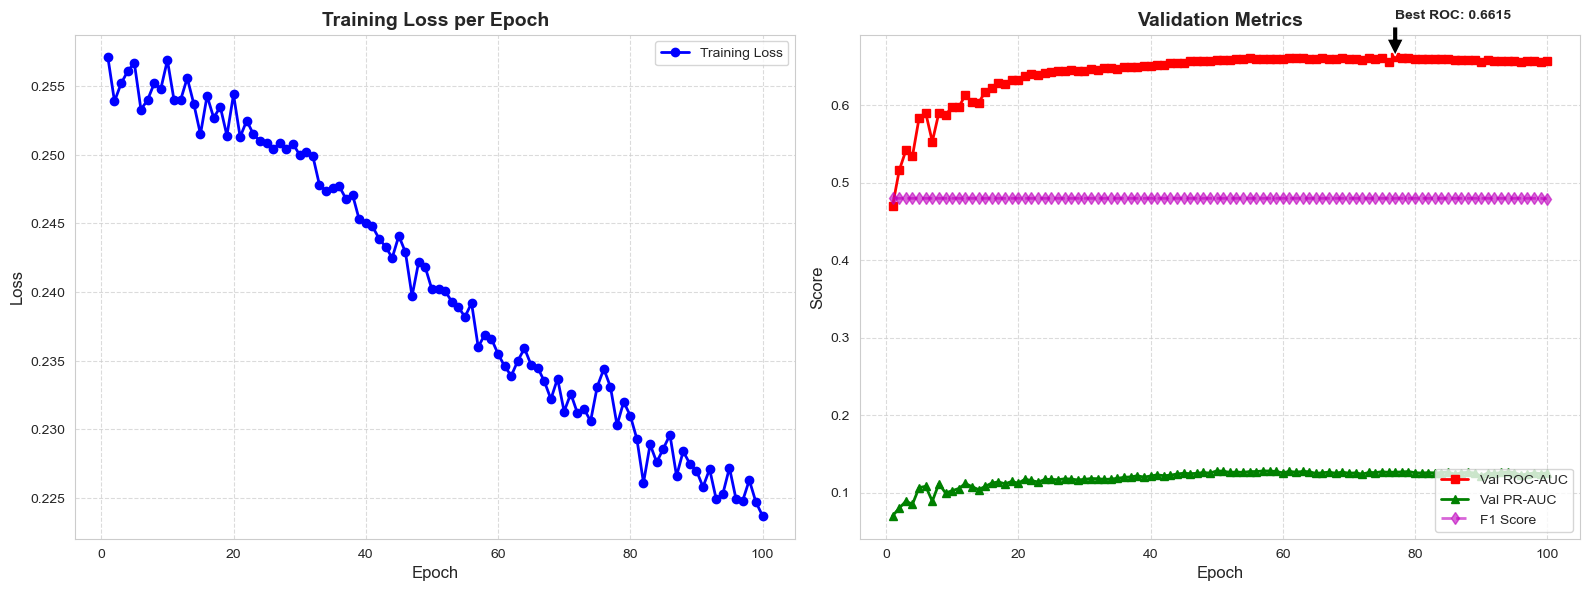

In [21]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- PASTE YOUR FULL LOG OUTPUT INSIDE THE QUOTES BELOW ---
log_output = """
Epoch: 1 | Loss: 0.2571 | Val ROC_AUC: 0.4703 | Val PR_AUC: 0.0700 | F1: 0.4797
Epoch: 2 | Loss: 0.2539 | Val ROC_AUC: 0.5158 | Val PR_AUC: 0.0799 | F1: 0.4797              
Epoch: 3 | Loss: 0.2552 | Val ROC_AUC: 0.5414 | Val PR_AUC: 0.0888 | F1: 0.4797                 
Epoch: 4 | Loss: 0.2561 | Val ROC_AUC: 0.5342 | Val PR_AUC: 0.0850 | F1: 0.4797                                     
Epoch: 5 | Loss: 0.2567 | Val ROC_AUC: 0.5833 | Val PR_AUC: 0.1063 | F1: 0.4797               
Epoch: 6 | Loss: 0.2533 | Val ROC_AUC: 0.5900 | Val PR_AUC: 0.1081 | F1: 0.4797
Epoch: 7 | Loss: 0.2540 | Val ROC_AUC: 0.5528 | Val PR_AUC: 0.0888 | F1: 0.4797     
Epoch: 8 | Loss: 0.2552 | Val ROC_AUC: 0.5903 | Val PR_AUC: 0.1115 | F1: 0.4797            
Epoch: 9 | Loss: 0.2548 | Val ROC_AUC: 0.5876 | Val PR_AUC: 0.0994 | F1: 0.4797                                                   
Epoch: 10 | Loss: 0.2569 | Val ROC_AUC: 0.5971 | Val PR_AUC: 0.1024 | F1: 0.4797                 
Epoch: 11 | Loss: 0.2540 | Val ROC_AUC: 0.5972 | Val PR_AUC: 0.1052 | F1: 0.4797              
Epoch: 12 | Loss: 0.2540 | Val ROC_AUC: 0.6132 | Val PR_AUC: 0.1117 | F1: 0.4797              
Epoch: 13 | Loss: 0.2556 | Val ROC_AUC: 0.6035 | Val PR_AUC: 0.1076 | F1: 0.4797                                                             
Epoch: 14 | Loss: 0.2537 | Val ROC_AUC: 0.6029 | Val PR_AUC: 0.1038 | F1: 0.4797                                                       
Epoch: 15 | Loss: 0.2515 | Val ROC_AUC: 0.6172 | Val PR_AUC: 0.1079 | F1: 0.4797               
Epoch: 16 | Loss: 0.2543 | Val ROC_AUC: 0.6215 | Val PR_AUC: 0.1123 | F1: 0.4797          
Epoch: 17 | Loss: 0.2527 | Val ROC_AUC: 0.6283 | Val PR_AUC: 0.1137 | F1: 0.4797            
Epoch: 18 | Loss: 0.2535 | Val ROC_AUC: 0.6275 | Val PR_AUC: 0.1113 | F1: 0.4797                   
Epoch: 19 | Loss: 0.2514 | Val ROC_AUC: 0.6325 | Val PR_AUC: 0.1143 | F1: 0.4797
Epoch: 20 | Loss: 0.2544 | Val ROC_AUC: 0.6320 | Val PR_AUC: 0.1121 | F1: 0.4797
Epoch: 21 | Loss: 0.2513 | Val ROC_AUC: 0.6372 | Val PR_AUC: 0.1171 | F1: 0.4797
Epoch: 22 | Loss: 0.2525 | Val ROC_AUC: 0.6407 | Val PR_AUC: 0.1156 | F1: 0.4797
Epoch: 23 | Loss: 0.2515 | Val ROC_AUC: 0.6388 | Val PR_AUC: 0.1135 | F1: 0.4797              
Epoch: 24 | Loss: 0.2510 | Val ROC_AUC: 0.6415 | Val PR_AUC: 0.1169 | F1: 0.4797
Epoch: 25 | Loss: 0.2509 | Val ROC_AUC: 0.6425 | Val PR_AUC: 0.1170 | F1: 0.4797
Epoch: 26 | Loss: 0.2504 | Val ROC_AUC: 0.6441 | Val PR_AUC: 0.1166 | F1: 0.4797
Epoch: 27 | Loss: 0.2509 | Val ROC_AUC: 0.6437 | Val PR_AUC: 0.1177 | F1: 0.4797                                                             
Epoch: 28 | Loss: 0.2504 | Val ROC_AUC: 0.6449 | Val PR_AUC: 0.1174 | F1: 0.4797
Epoch: 29 | Loss: 0.2508 | Val ROC_AUC: 0.6444 | Val PR_AUC: 0.1163 | F1: 0.4797
Epoch: 30 | Loss: 0.2500 | Val ROC_AUC: 0.6435 | Val PR_AUC: 0.1170 | F1: 0.4797
Epoch: 31 | Loss: 0.2502 | Val ROC_AUC: 0.6465 | Val PR_AUC: 0.1181 | F1: 0.4797
Epoch: 32 | Loss: 0.2499 | Val ROC_AUC: 0.6458 | Val PR_AUC: 0.1179 | F1: 0.4797    
Epoch: 33 | Loss: 0.2478 | Val ROC_AUC: 0.6474 | Val PR_AUC: 0.1170 | F1: 0.4797
Epoch: 34 | Loss: 0.2474 | Val ROC_AUC: 0.6479 | Val PR_AUC: 0.1174 | F1: 0.4797
Epoch: 35 | Loss: 0.2476 | Val ROC_AUC: 0.6470 | Val PR_AUC: 0.1183 | F1: 0.4797    
Epoch: 36 | Loss: 0.2477 | Val ROC_AUC: 0.6487 | Val PR_AUC: 0.1197 | F1: 0.4797
Epoch: 37 | Loss: 0.2468 | Val ROC_AUC: 0.6488 | Val PR_AUC: 0.1202 | F1: 0.4797
Epoch: 38 | Loss: 0.2471 | Val ROC_AUC: 0.6489 | Val PR_AUC: 0.1216 | F1: 0.4797
Epoch: 39 | Loss: 0.2453 | Val ROC_AUC: 0.6498 | Val PR_AUC: 0.1200 | F1: 0.4797
Epoch: 40 | Loss: 0.2450 | Val ROC_AUC: 0.6510 | Val PR_AUC: 0.1213 | F1: 0.4797
Epoch: 41 | Loss: 0.2448 | Val ROC_AUC: 0.6519 | Val PR_AUC: 0.1228 | F1: 0.4797
Epoch: 42 | Loss: 0.2439 | Val ROC_AUC: 0.6511 | Val PR_AUC: 0.1218 | F1: 0.4797     
Epoch: 43 | Loss: 0.2433 | Val ROC_AUC: 0.6539 | Val PR_AUC: 0.1223 | F1: 0.4797
Epoch: 44 | Loss: 0.2425 | Val ROC_AUC: 0.6539 | Val PR_AUC: 0.1240 | F1: 0.4797
Epoch: 45 | Loss: 0.2441 | Val ROC_AUC: 0.6547 | Val PR_AUC: 0.1249 | F1: 0.4797
Epoch: 46 | Loss: 0.2429 | Val ROC_AUC: 0.6566 | Val PR_AUC: 0.1244 | F1: 0.4797
Epoch: 47 | Loss: 0.2397 | Val ROC_AUC: 0.6567 | Val PR_AUC: 0.1248 | F1: 0.4797
Epoch: 48 | Loss: 0.2422 | Val ROC_AUC: 0.6565 | Val PR_AUC: 0.1259 | F1: 0.4797
Epoch: 49 | Loss: 0.2418 | Val ROC_AUC: 0.6569 | Val PR_AUC: 0.1251 | F1: 0.4797
Epoch: 50 | Loss: 0.2402 | Val ROC_AUC: 0.6588 | Val PR_AUC: 0.1279 | F1: 0.4797
Epoch: 51 | Loss: 0.2402 | Val ROC_AUC: 0.6586 | Val PR_AUC: 0.1276 | F1: 0.4797
Epoch: 52 | Loss: 0.2401 | Val ROC_AUC: 0.6588 | Val PR_AUC: 0.1260 | F1: 0.4797
Epoch: 53 | Loss: 0.2393 | Val ROC_AUC: 0.6592 | Val PR_AUC: 0.1265 | F1: 0.4797
Epoch: 54 | Loss: 0.2389 | Val ROC_AUC: 0.6596 | Val PR_AUC: 0.1260 | F1: 0.4797
Epoch: 55 | Loss: 0.2382 | Val ROC_AUC: 0.6605 | Val PR_AUC: 0.1271 | F1: 0.4797
Epoch: 56 | Loss: 0.2392 | Val ROC_AUC: 0.6598 | Val PR_AUC: 0.1271 | F1: 0.4797
Epoch: 57 | Loss: 0.2360 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1279 | F1: 0.4797
Epoch: 58 | Loss: 0.2369 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1278 | F1: 0.4797
Epoch: 59 | Loss: 0.2366 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1272 | F1: 0.4797
Epoch: 60 | Loss: 0.2355 | Val ROC_AUC: 0.6597 | Val PR_AUC: 0.1255 | F1: 0.4797
Epoch: 61 | Loss: 0.2346 | Val ROC_AUC: 0.6604 | Val PR_AUC: 0.1273 | F1: 0.4797
Epoch: 62 | Loss: 0.2339 | Val ROC_AUC: 0.6603 | Val PR_AUC: 0.1263 | F1: 0.4797
Epoch: 63 | Loss: 0.2350 | Val ROC_AUC: 0.6605 | Val PR_AUC: 0.1272 | F1: 0.4797
Epoch: 64 | Loss: 0.2359 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1269 | F1: 0.4797
Epoch: 65 | Loss: 0.2347 | Val ROC_AUC: 0.6601 | Val PR_AUC: 0.1247 | F1: 0.4797
Epoch: 66 | Loss: 0.2345 | Val ROC_AUC: 0.6603 | Val PR_AUC: 0.1256 | F1: 0.4797   
Epoch: 67 | Loss: 0.2335 | Val ROC_AUC: 0.6599 | Val PR_AUC: 0.1263 | F1: 0.4797
Epoch: 68 | Loss: 0.2322 | Val ROC_AUC: 0.6600 | Val PR_AUC: 0.1250 | F1: 0.4797
Epoch: 69 | Loss: 0.2337 | Val ROC_AUC: 0.6607 | Val PR_AUC: 0.1264 | F1: 0.4797          
Epoch: 70 | Loss: 0.2313 | Val ROC_AUC: 0.6597 | Val PR_AUC: 0.1250 | F1: 0.4797
Epoch: 71 | Loss: 0.2326 | Val ROC_AUC: 0.6598 | Val PR_AUC: 0.1254 | F1: 0.4797
Epoch: 72 | Loss: 0.2312 | Val ROC_AUC: 0.6585 | Val PR_AUC: 0.1238 | F1: 0.4797
Epoch: 73 | Loss: 0.2315 | Val ROC_AUC: 0.6602 | Val PR_AUC: 0.1259 | F1: 0.4797
Epoch: 74 | Loss: 0.2306 | Val ROC_AUC: 0.6600 | Val PR_AUC: 0.1258 | F1: 0.4797
Epoch: 75 | Loss: 0.2331 | Val ROC_AUC: 0.6607 | Val PR_AUC: 0.1268 | F1: 0.4797
Epoch: 76 | Loss: 0.2344 | Val ROC_AUC: 0.6554 | Val PR_AUC: 0.1261 | F1: 0.4797
Epoch: 77 | Loss: 0.2331 | Val ROC_AUC: 0.6615 | Val PR_AUC: 0.1263 | F1: 0.4797
Epoch: 78 | Loss: 0.2303 | Val ROC_AUC: 0.6607 | Val PR_AUC: 0.1266 | F1: 0.4797
Epoch: 79 | Loss: 0.2320 | Val ROC_AUC: 0.6608 | Val PR_AUC: 0.1271 | F1: 0.4797
Epoch: 80 | Loss: 0.2310 | Val ROC_AUC: 0.6599 | Val PR_AUC: 0.1256 | F1: 0.4797
Epoch: 81 | Loss: 0.2293 | Val ROC_AUC: 0.6594 | Val PR_AUC: 0.1252 | F1: 0.4797
Epoch: 82 | Loss: 0.2261 | Val ROC_AUC: 0.6597 | Val PR_AUC: 0.1257 | F1: 0.4797
Epoch: 83 | Loss: 0.2289 | Val ROC_AUC: 0.6592 | Val PR_AUC: 0.1254 | F1: 0.4797
Epoch: 84 | Loss: 0.2276 | Val ROC_AUC: 0.6589 | Val PR_AUC: 0.1258 | F1: 0.4797
Epoch: 85 | Loss: 0.2286 | Val ROC_AUC: 0.6594 | Val PR_AUC: 0.1265 | F1: 0.4797
Epoch: 86 | Loss: 0.2296 | Val ROC_AUC: 0.6578 | Val PR_AUC: 0.1237 | F1: 0.4797
Epoch: 87 | Loss: 0.2266 | Val ROC_AUC: 0.6586 | Val PR_AUC: 0.1255 | F1: 0.4797
Epoch: 88 | Loss: 0.2284 | Val ROC_AUC: 0.6586 | Val PR_AUC: 0.1261 | F1: 0.4797
Epoch: 89 | Loss: 0.2275 | Val ROC_AUC: 0.6577 | Val PR_AUC: 0.1253 | F1: 0.4797
Epoch: 90 | Loss: 0.2270 | Val ROC_AUC: 0.6557 | Val PR_AUC: 0.1211 | F1: 0.4797
Epoch: 91 | Loss: 0.2258 | Val ROC_AUC: 0.6576 | Val PR_AUC: 0.1253 | F1: 0.4797
Epoch: 92 | Loss: 0.2271 | Val ROC_AUC: 0.6569 | Val PR_AUC: 0.1246 | F1: 0.4797
Epoch: 93 | Loss: 0.2249 | Val ROC_AUC: 0.6572 | Val PR_AUC: 0.1259 | F1: 0.4797
Epoch: 94 | Loss: 0.2253 | Val ROC_AUC: 0.6571 | Val PR_AUC: 0.1266 | F1: 0.4797
Epoch: 95 | Loss: 0.2272 | Val ROC_AUC: 0.6569 | Val PR_AUC: 0.1258 | F1: 0.4797
Epoch: 96 | Loss: 0.2249 | Val ROC_AUC: 0.6556 | Val PR_AUC: 0.1227 | F1: 0.4797
Epoch: 97 | Loss: 0.2248 | Val ROC_AUC: 0.6563 | Val PR_AUC: 0.1240 | F1: 0.4797
Epoch: 98 | Loss: 0.2263 | Val ROC_AUC: 0.6568 | Val PR_AUC: 0.1253 | F1: 0.4797 
Epoch: 99 | Loss: 0.2247 | Val ROC_AUC: 0.6562 | Val PR_AUC: 0.1244 | F1: 0.4797
Epoch: 100 | Loss: 0.2237 | Val ROC_AUC: 0.6568 | Val PR_AUC: 0.1255 | F1: 0.479
"""
# -----------------------------------------------------------

# Lists to store parsed data
epochs = []
losses = []
roc_aucs = []
pr_aucs = []
f1_scores = []

# Parse the log string line by line
print("Parsing logs...")
lines = log_output.strip().split('\n')
for line in lines:
    try:
        # Extract values using Regex based on your format: "Epoch: 86 | Loss: ..."
        epoch_match = re.search(r'Epoch:\s*(\d+)', line)
        loss_match = re.search(r'Loss:\s*([\d.]+)', line)
        roc_match = re.search(r'Val ROC_AUC:\s*([\d.]+)', line)
        pr_match = re.search(r'Val PR_AUC:\s*([\d.]+)', line)
        f1_match = re.search(r'F1:\s*([\d.]+)', line)

        if epoch_match and loss_match and roc_match:
            epochs.append(int(epoch_match.group(1)))
            losses.append(float(loss_match.group(1)))
            roc_aucs.append(float(roc_match.group(1)))
            if pr_match:
                pr_aucs.append(float(pr_match.group(1)))
            if f1_match:
                f1_scores.append(float(f1_match.group(1)))
    except Exception as e:
        print(f"Skipping line due to error: {line} -> {e}")
        continue

if not epochs:
    print("No valid log lines found! Please ensure you pasted the output into the 'log_output' variable correctly.")
else:
    print(f"Successfully parsed {len(epochs)} epochs.")

    # --- Plotting ---
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Training Loss
    ax1.plot(epochs, losses, 'b-o', linewidth=2, label='Training Loss')
    ax1.set_title('Training Loss per Epoch', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Validation Metrics
    ax2.plot(epochs, roc_aucs, 'r-s', linewidth=2, label='Val ROC-AUC')
    if pr_aucs:
        ax2.plot(epochs, pr_aucs, 'g-^', linewidth=2, label='Val PR-AUC')
    if f1_scores:
        ax2.plot(epochs, f1_scores, 'm-d', linewidth=2, linestyle='--', alpha=0.6, label='F1 Score')

    # Highlight Best ROC-AUC
    max_roc = max(roc_aucs)
    best_epoch = epochs[roc_aucs.index(max_roc)]
    ax2.annotate(f'Best ROC: {max_roc:.4f}', 
                 xy=(best_epoch, max_roc), 
                 xytext=(best_epoch, max_roc + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10, fontweight='bold')

    ax2.set_title('Validation Metrics', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.legend(loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()